<h1>Amazon SageMaker로 R 사용하기</h1>

이 샘플 노트북은 [Amazon SageMaker](https://aws.amazon.com/sagemaker/) 및 [R](https://www.r-project.org/)을 사용하여 기계 학습 (ML) 모델에서 예측을 학습, 배포 및 검색하는 방법을 설명합니다. 여기서는 껍데기의 고리 수로 전복 연령을 예측해 봅니다. [reticulate](https://rstudio.github.io/reticulate/) 패키지는 R에서 [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/latest/index.html)의 API 호출을 할 수 있게 해 주는 인터페이스입니다. 또한 이 `reticulate` 패키지는 R과 Python object들을 변환해 주는 역할을 수행합니다. 그리고 Amazon SageMaker는 대규모 ML 모델을 훈련하고 배포할 수 있는 서버리스 데이터 사이언스 환경을 제공합니다.

<h3>R에서 Amazon SageMaker Python SDK 호출 가능한 환경 만들기</h3>

먼저, `reticulate` library를 로드하고 `sagemaker` 파이썬 모듈을 import 합니다. 모듈이 로드되고 나면 파이썬에서 `.` 으로 사용하던 클래스 notation을 R의 `$`로 사용할 수 있습니다.

In [1]:
# 경고를 끕니다 - Turn warnings off globally
options(warn=-1)

In [2]:
# 틱톡을 이용하여 코드 실행 시간을 측정합니다 - Install TicToc to measure code running time
install.packages('tictoc', repos='http://cran.us.r-project.org')
library(tictoc)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
library(reticulate)
sagemaker <- import('sagemaker')

<h3>데이터 저장소를 생성하고 엑세스하기</h3>

이 `Session` 클래스는 Amazon SageMaker에서 다음과 같은 [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) 리소스들을 사용할 수 있는 방법을 제공해 줍니다.

* [S3](https://boto3.readthedocs.io/en/latest/reference/services/s3.html)
* [SageMaker](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html)
* [SageMakerRuntime](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker-runtime.html)

데이터를 저장할 [Amazon Simple Storage Service](https://aws.amazon.com/s3/) 버킷을 만들어 봅시다.

In [4]:
session <- sagemaker$Session()
bucket <- session$default_bucket()

**참고** - 이 `default_bucket` 함수는 아래와 같은 형식의 이름으로 새 Amazon S3 버킷을 생성합니다: 

`sagemaker-<aws-region-name>-<aws account number>`

IAM role의 [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) 을 지정하여 Amazon SageMaker가 Amazon S3 버킷에 접근할 수 있도록 해 줍니다. 이 노트북을 생성하는 데 사용된 IAM role을 이용할 수도 있습니다. 

In [5]:
role_arn <- sagemaker$get_execution_role()

<h3>데이터셋 다운로드하고 프로세싱하기</h3>

이 모델은 [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)의 [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) 을 사용합니다. 먼저, 데이터를 다운로드하고 [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis)를 수행합니다. tidyverse packages를 이용하여 데이터를 읽고, 시각화하고, Amazon SageMaker로 다루기에 적합한 ML 포맷으로 데이터를 변환합니다.


In [6]:
library(readr)
data_file <- 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone <- read_csv(file = data_file, col_names = FALSE)
names(abalone) <- c('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings')
head(abalone)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)


sex length diameter height whole_weight shucked_weight viscera_weight
1 M   0.455  0.365    0.095  0.5140       0.2245         0.1010        
2 M   0.350  0.265    0.090  0.2255       0.0995         0.0485        
3 F   0.530  0.420    0.135  0.6770       0.2565         0.1415        
4 M   0.440  0.365    0.125  0.5160       0.2155         0.1140        
5 I   0.330  0.255    0.080  0.2050       0.0895         0.0395        
6 I   0.425  0.300    0.095  0.3515       0.1410         0.0775        
  shell_weight rings
1 0.150        15   
2 0.070         7   
3 0.210         9   
4 0.155        10   
5 0.055         7   
6 0.120         8

위의 출력을 보면 factor 데이터 타입에 적합한 `sex`가 현재 character 데이터 타입으로 되어 있는 것을 확인할 수 있습니다. (F는 암컷, M은 수컷, 그리고 I는 새끼입니다) `sex`를 factor 데이터 타입으로 바꾸고 데이터셋의 통계를 살펴보겠습니다:

In [17]:
abalone$sex <- as.factor(abalone$sex)
summary(abalone)

 sex          length          diameter          height        whole_weight   
 F:1307   Min.   :0.0750   Min.   :0.0550   Min.   :0.0100   Min.   :0.0020  
 I:1340   1st Qu.:0.4500   1st Qu.:0.3500   1st Qu.:0.1150   1st Qu.:0.4422  
 M:1528   Median :0.5450   Median :0.4250   Median :0.1400   Median :0.8000  
          Mean   :0.5241   Mean   :0.4079   Mean   :0.1396   Mean   :0.8290  
          3rd Qu.:0.6150   3rd Qu.:0.4800   3rd Qu.:0.1650   3rd Qu.:1.1535  
          Max.   :0.8150   Max.   :0.6500   Max.   :1.1300   Max.   :2.8255  
 shucked_weight   viscera_weight    shell_weight        rings       
 Min.   :0.0010   Min.   :0.0005   Min.   :0.0015   Min.   : 1.000  
 1st Qu.:0.1862   1st Qu.:0.0935   1st Qu.:0.1300   1st Qu.: 8.000  
 Median :0.3360   Median :0.1710   Median :0.2340   Median : 9.000  
 Mean   :0.3595   Mean   :0.1807   Mean   :0.2388   Mean   : 9.935  
 3rd Qu.:0.5020   3rd Qu.:0.2530   3rd Qu.:0.3287   3rd Qu.:11.000  
 Max.   :1.4880   Max.   :0.7600   Max. 

위의 summary를 보면 `height`의 최소값이 0인 것을 볼 수 있습니다.

각 `sex`의 값에 대해 `rings`와 `height` 간의 관계를 플로팅하여 어떤 전복의 키가 0인지 시각적으로 살펴보겠습니다.

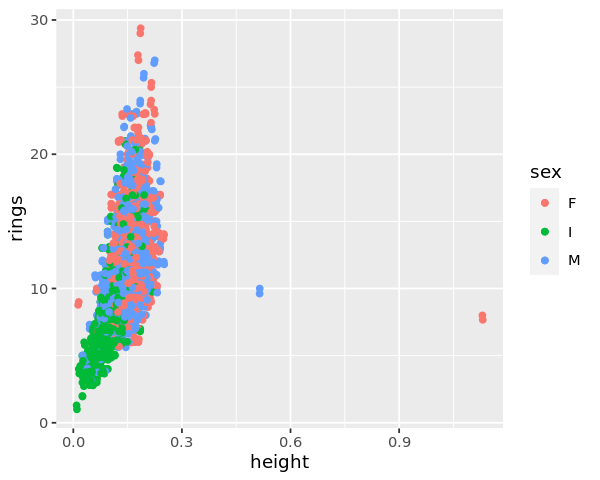

In [16]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height = 4) 
ggplot(abalone, aes(x = height, y = rings, color = sex)) + geom_point() + geom_jitter()

또는 [RBokeh](https://hafen.github.io/rbokeh/) 패키지를 사용해서 인터랙티브한 시각화를 해 볼 수도 있습니다. 패키지 문서 설명에 따르면, 
> "*Bokeh는 웹 기반 플롯을 만들기 위한 유연하고 강력한 선언적 프레임 워크를 제공하는 시각화 라이브러리입니다. Bokeh는 HTML 캔버스를 사용하여 플롯을 렌더링하고 상호 작용할 수 있는 많은 메커니즘을 제공합니다. Bokeh는 현재 Python, Scala, Julia 및 R 인터페이스를 제공합니다.*"

`rbokeh` 는 SageMaker의 R kernel 커널에 표준으로 제공됩니다. 아래와 같이 이 라이브러리를 가져올 수 있습니다:

>`library(rbokeh)`

아래는 RBokeh를 사용하여 만든 인터랙티브 차트의 예입니다.

In [18]:
# Import rbokeh
library(rbokeh)

In [19]:
p <- figure() %>%
  ly_points(height, rings, data = abalone,
    hover = list(height, rings))
p

HTML widgets cannot be represented in plain text (need html)

이 플롯에서 여러 개의 outlier들을 볼 수 있습니다. 두 새끼 전복들의 키가 0으로 표시되어 있고, 몇몇 암컷, 수컷 전복들이 다른 전복들보다 훨씬 큰 키로 표시되어 있네요. 키가 0으로 표기된 두 새끼 전복을 필터링해 보겠습니다.

In [20]:
library(dplyr)
abalone <- abalone %>%
  filter(height != 0)

<h3>모델 트레이닝을 위해 데이터셋 준비하기</h3>

이 모델을 위해서는 세 개의 데이터셋 - 트레이닝용, 테스팅용, 그리고 검증용 - 이 필요합니다. 먼저, `sex`를 [dummy variable](https://en.wikipedia.org/wiki/Dummy_variable_(statistics))로 변경하고 대상인 `rings`를 첫 번째 열로 바꿔줍니다. Amazon SageMaker 알고리즘은 대상이 데이터셋의 첫번째 열에 있어야 합니다.

In [21]:
abalone <- abalone %>%
  mutate(female = as.integer(ifelse(sex == 'F', 1, 0)),
         male = as.integer(ifelse(sex == 'M', 1, 0)),
         infant = as.integer(ifelse(sex == 'I', 1, 0))) %>%
  select(-sex)
abalone <- abalone %>%
  select(rings:infant, length:shell_weight)
head(abalone)

rings female male infant length diameter height whole_weight shucked_weight
1 15    0      1    0      0.455  0.365    0.095  0.5140       0.2245        
2  7    0      1    0      0.350  0.265    0.090  0.2255       0.0995        
3  9    1      0    0      0.530  0.420    0.135  0.6770       0.2565        
4 10    0      1    0      0.440  0.365    0.125  0.5160       0.2155        
5  7    0      0    1      0.330  0.255    0.080  0.2050       0.0895        
6  8    0      0    1      0.425  0.300    0.095  0.3515       0.1410        
  viscera_weight shell_weight
1 0.1010         0.150       
2 0.0485         0.070       
3 0.1415         0.210       
4 0.1140         0.155       
5 0.0395         0.055       
6 0.0775         0.120

다음으로 ML 알고리즘 학습을 위해 데이터의 70 %를 샘플링합니다. 나머지 30 %를 두 개로 나눠 테스트용과 검증용으로 사용하겠습니다:

In [22]:
abalone_train <- abalone %>%
  sample_frac(size = 0.7)
abalone <- anti_join(abalone, abalone_train)
abalone_test <- abalone %>%
  sample_frac(size = 0.5)
abalone_valid <- anti_join(abalone, abalone_test)

Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")
Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")


모델을 트레이닝할 수 있도록 트레이닝 및 검증용 데이터를 Amazon S3에 업로드하겠습니다. 먼저 트레이닝 및 검증용 데이터셋을 .csv 형식으로 로컬 파일 시스템에 저장합니다.

In [23]:
write_csv(abalone_train, 'abalone_train.csv', col_names = FALSE)
write_csv(abalone_valid, 'abalone_valid.csv', col_names = FALSE)

그 다음, 이 두 개의 데이터셋을 Amazon S3 버킷에 data라는 키 접두사를 붙여 업로드합니다.

In [24]:
s3_train <- session$upload_data(path = 'abalone_train.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')
s3_valid <- session$upload_data(path = 'abalone_valid.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')

마지막으로 Amazon SageMaker 알고리즘에 Amazon S3에서의 입력 형식을 정의해 줍니다:

In [25]:
s3_train_input <- sagemaker$s3_input(s3_data = s3_train,
                                     content_type = 'csv')
s3_valid_input <- sagemaker$s3_input(s3_data = s3_valid,
                                     content_type = 'csv')

<h3>모델 트레이닝하기</h3>

Amazon SageMaker 알고리즘들은 [Docker](https://www.docker.com/) 컨테이너 형태로 사용 가능합니다. [XGBoost](https://en.wikipedia.org/wiki/Xgboost) 모델을 트레이닝하기 위해, AWS 리전 내의 [Amazon Elastic Container Registry](https://aws.amazon.com/ecr/) (Amazon ECR)에 저장되어 있는 트레이닝 컨테이너를 지정하겠습니다.

In [26]:
registry <- sagemaker$amazon$amazon_estimator$registry(session$boto_region_name, algorithm='xgboost')
container <- paste(registry, '/xgboost:latest', sep='')
container

[1] "306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:latest"

Amazon SageMaker [Estimator](http://sagemaker.readthedocs.io/en/latest/estimators.html)를 정의해 줍니다. 이 Estimator는 Docker로 컨테이너화 되어 있는 알고리즘을 트레이닝하는 데에 사용됩니다. 이 Estimator를 생성할 때에는 아래와 같은 인수들을 사용할 수 있습니다:
* **image_name** - 트레이닝에 사용할 컨테이너 이미지 이름
* **role** - Amazon SageMaker의 서비스 역할
* **train_instance_count** - 트레이닝에 사용할 Amazon EC2 인스턴스들의 개수
* **train_instance_type** - 트레이닝에 사용할 Amazon EC2 인스턴스의 유형
* **train_volume_size** - 트레이닝하는 동안 입력 데이터를 저장할 [Amazon Elastic Block Store](https://aws.amazon.com/ebs/) (Amazon EBS) 볼륨의 크기(GB)
* **train_max_run** - 최대 트레이닝 시간 (타임아웃)
* **input_mode** - 알고리즘이 지원하는 입력 방식
* **output_path** - 트레이닝 결과(모델 artifact들과 출력 파일들)를 저장할 Amazon S3의 경로
* **output_kms_key** - 트레이닝 결과를 암호화할 [AWS Key Management Service](https://aws.amazon.com/kms/) (AWS KMS)의 키
* **base_job_name** - 트레이닝 작업에 접두사로 붙일 이름
* **sagemaker_session** - Amazon SageMaker API과의 인터렉션을 관리할 세션 오브젝트

In [27]:
s3_output <- paste0('s3://', bucket, '/output')
estimator <- sagemaker$estimator$Estimator(image_name = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.large',
                                           train_volume_size = 30L,
                                           train_max_run = 3600L,
                                           input_mode = 'File',
                                           output_path = s3_output,
                                           output_kms_key = NULL,
                                           base_job_name = NULL,
                                           sagemaker_session = NULL)

**참고** - R에서의 `NULL`의 경우 파이썬에서는 `None`으로 사용합니다.

[XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html)를 지정하고 모델을 피팅해 봅니다. 트레이닝 라운드 수를 XGBoost 라이브러리의 통상 기본값인 100으로 설정합니다. 또한 현재 타임스탬프를 기반으로 입력 데이터와 작업 이름을 지정해 줍니다.

In [28]:
tic("Model Fitting")
estimator$set_hyperparameters(num_round = 100L)
job_name <- paste('sagemaker-train-xgboost', format(Sys.time(), '%H-%M-%S'), sep = '-')
input_data <- list('train' = s3_train_input,
                   'validation' = s3_valid_input)
estimator$fit(inputs = input_data,
              job_name = job_name)
toc()

Model Fitting: 221.606 sec elapsed


트레이닝이 끝나고 나면, Amazon SageMaker는 모델의 바이너리(gzip tarball)를 위에서 지정한 Amazon S3 출력 위치에 복사해 둡니다. Amazon S3의 전체 경로는 아래 명령어로 확인 가능합니다.

In [29]:
estimator$model_data

[1] "s3://sagemaker-ap-northeast-2-005481306090/output/sagemaker-train-xgboost-07-12-41/output/model.tar.gz"

<h3>모델 배포하기</h3>

Amazon SageMaker를 이용하면 쉽고 간단하게 모델을 배포하여([deploy your model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html)), 사용자들이 HTTPS request를 보낼 수 있는 API 엔드포인트를 제공할 수 있습니다. 우리가 방금 트레이닝시킨 모델을 `ml.t2.medium` 인스턴스에 배포해 보겠습니다.

In [30]:
tic("Model Deployment")
model_endpoint <- estimator$deploy(initial_instance_count = 1L,
                                   instance_type = 'ml.t2.medium')
toc()

Model Deployment: 542.199 sec elapsed


<h3>모델을 이용하여 예측 생성하기</h3>

테스트 데이터를 사용하여 예측을 만들어 보겠습니다. 엔드포인트 설정에 `text/csv` 와 `csv_serializer`를 지정해서 콤마로 구분된(comma-separated) csv 텍스트를 JSON 포맷으로 직렬화하여 넘겨줍니다.

In [31]:
model_endpoint$content_type <- 'text/csv'
model_endpoint$serializer <- sagemaker$predictor$csv_serializer

대상 열(column)을 지우고 처음 500개의 관찰(행)들을 열의 이름이 없는 매트릭스로 변환합니다.

In [32]:
abalone_test <- abalone_test[-1]
num_predict_rows <- 500
test_sample <- as.matrix(abalone_test[1:num_predict_rows, ])
dimnames(test_sample)[[2]] <- NULL

**참고** - 관찰 행의 수를 500으로 설정한 이유는 엔드포인트의 제한을 넘기지 않기 위해서입니다.

엔드포인트로부터 예측을 생성하고, 결과로 나온 콤마로 구분된(comma-separated) 문자열을 변환해 보겠습니다.

In [33]:
tic("Invoke Endpoint")
library(stringr)
predictions <- model_endpoint$predict(test_sample)
predictions <- str_split(predictions, pattern = ',', simplify = TRUE)
predictions <- as.numeric(predictions)
toc()

Invoke Endpoint: 0.533 sec elapsed


예측한 고리의 수가 기록된 열을 테스트 데이터에 바인드합니다.

In [34]:
# Convert predictions to Integer
abalone_test <- cbind(predicted_rings = as.integer(predictions), 
                      abalone_test[1:num_predict_rows, ])
head(abalone_test)

predicted_rings female male infant length diameter height whole_weight
1 10              1      0    0      0.625  0.495    0.160  1.1115      
2 10              1      0    0      0.530  0.410    0.130  0.6965      
3 16              0      1    0      0.520  0.435    0.195  0.9730      
4  7              0      1    0      0.350  0.265    0.090  0.2265      
5  9              0      0    1      0.505  0.400    0.145  0.7045      
6  6              0      1    0      0.310  0.225    0.080  0.1345      
  shucked_weight viscera_weight shell_weight
1 0.4495         0.2825         0.345       
2 0.3020         0.1935         0.200       
3 0.2985         0.2135         0.355       
4 0.0995         0.0575         0.065       
5 0.3340         0.1425         0.207       
6 0.0540         0.0240         0.050

<h3>엔드포인트 삭제하기</h3>

모델을 모두 사용했다면, 엔드포인트를 삭제하여 비용이 낭비되지 않도록 합니다.

In [35]:
session$delete_endpoint(model_endpoint$endpoint)